In [ ]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append('C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation')

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import scipy
from scipy.optimize import minimize
from functools import partial
import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from IPython.display import display, Math

import pandas
import proplot as pplt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition
import seaborn as sns

from utils import *
from analysis_functions import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 5})

In [355]:
#load model
current_dir = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation"
exp_extension = "\\experiments\\poisson_clicks\\perfect_model\\"
# exp_extension = "\\experiments\\poisson_clicks\\"

# N100: 3892
# N30: 8288
#with diagonal constraint: 5398
# with spectrum constraint: 1667906971, 6168
# without: 6701
exp_list = glob.glob(current_dir + exp_extension + "\\exp*8288") #92
# exp_list = sorted(exp_list, key = lambda x: int(x.split("Nrec")[-1].split("_")[-1]))
exp_path = exp_list[0]
exp_path
exp_list

['C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\perfect_model\\exp_Nrec30_1667838288']

In [356]:
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
training_kwargs['device'] = 'cpu'
device = training_kwargs['device']
makedirs(training_kwargs['figures_path'] )
idx = int(re.search(r'\d+', exp_path).group())
training_kwargs['constrain_spectrum'] = False
rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu', constrain_spectrum=training_kwargs['constrain_spectrum']).to(device)

rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\exp_Nrec30_1667838288\weights1667838288.pth


In [362]:
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key].cpu()) for key in rnn_model.state_dict().keys()}
#input weights
try:
    W_hh = weights_dict['rnn.weight_hh_l0']
except:
    W_hh = weights_dict['rnn.parametrizations.weight_hh_l0.original']
# W_hh.to_numpy()

### Fixed points from asymptotic behavior

In [363]:
N_test_batch = 10**2
training_kwargs['T'] = 20000
training_kwargs['hidden_initial_variance'] = 10
# equal_clicks  
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x, y, output_mask, trial_params = data_set = pd.get_trial_batch() #generate self.N_batch trials
x *= 0

yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=10)
yhat = yhat.cpu().detach().numpy()
hidden_states = hidden_states.cpu().detach().numpy()

C:\Users\abel_\AppData\Local\Temp\ipykernel_6104\2506185281.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(hs, ax=ax, label='Click difference')


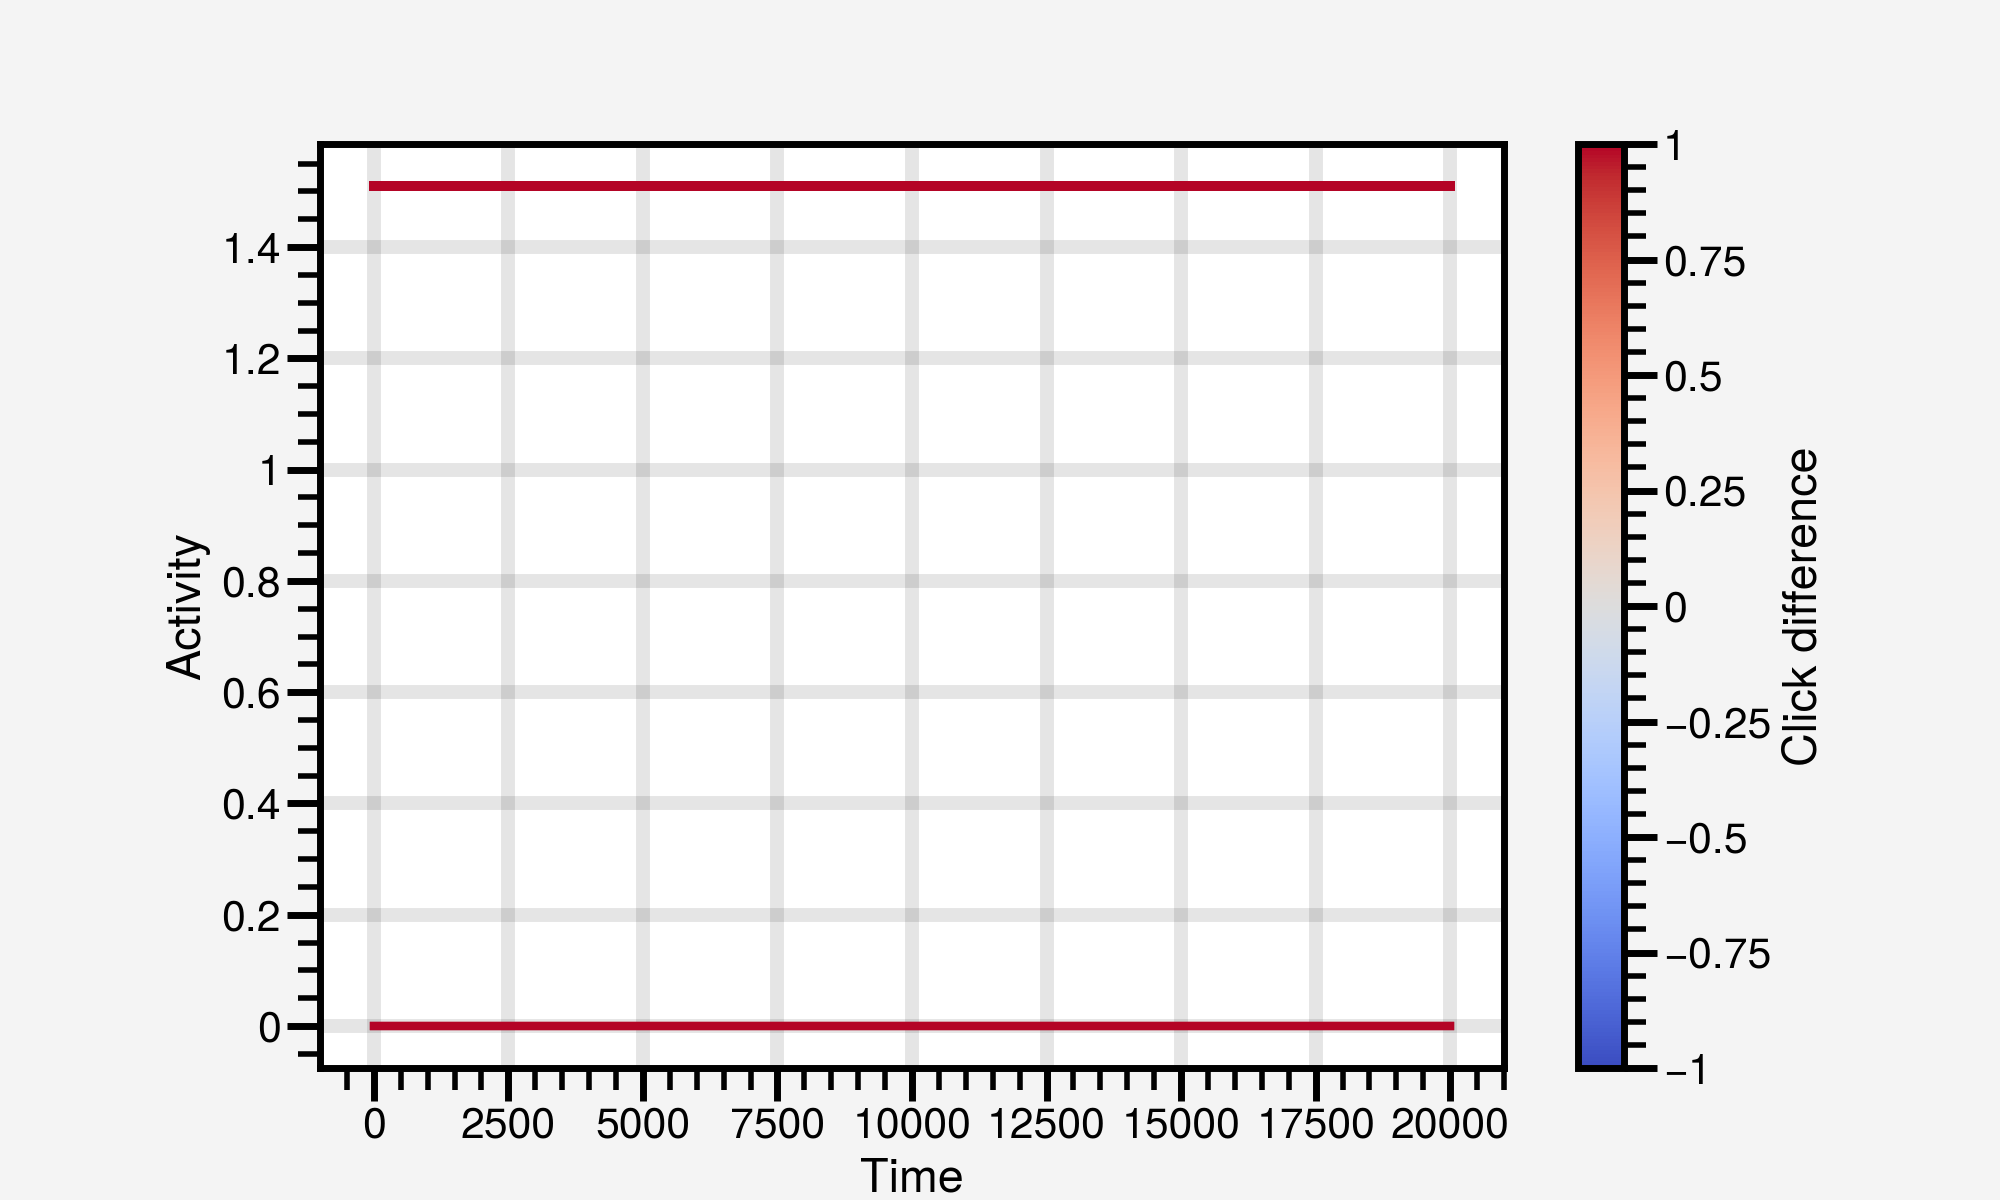

In [364]:
hidden_i = 0
sns.set_context("poster", font_scale = .7, rc={"grid.linewidth": 5})
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

clickdiff = N_clicks[:,0]-N_clicks[:,1]
clickdiff *= 0
clickdiff += 1
plot_trajectories_clickdiff(hidden_states[:,-10:,:], hidden_i=0, clickdiff=clickdiff, vextrema = 1, file_name='hidden_activity', path=training_kwargs['figures_path'])

In [416]:
#fixed points at end of trials:
fxd_pnts = np.unique(np.round(hidden_states[:,-1,:], 6), axis=0)

from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(fxd_pnts,fxd_pnts)

find_stabilities(fxd_pnts, W_hh, tol = 10**-4);

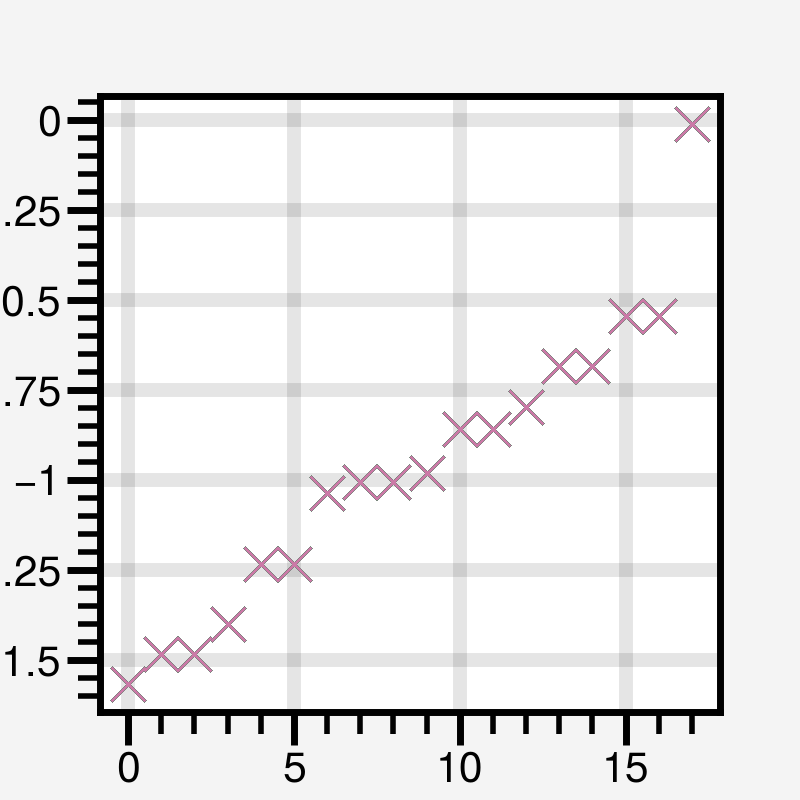

In [418]:
tol = 1e-4
for x in fxd_pnts:
    support = np.where(x>tol)[0]

    r = np.array(support)
    eigenvalues = np.linalg.eigvals(W_hh[r[:,None], r]-np.eye(len(support)))
    plt.plot(np.sort(np.real(eigenvalues)), 'x')

In [401]:
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key]) for key in rnn_model.state_dict().keys()}
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] 
W_ih = weights_dict['rnn.weight_ih_l0'] 
b_h = weights_dict['rnn.bias_hh_l0']
b_in = weights_dict['rnn.bias_ih_l0']


b = b_in + b_h
b = b[0].to_numpy()
W_hh = W_hh.numpy()
W_ih = W_ih.to_numpy()

I = np.array([0.,0.,0.,0.])

fun = partial(relu_step, W=W_hh, b=b)

In [424]:
N_rec = training_kwargs['N_rec']
x0 = np.random.random(N_rec) #fxd_pnts[3]*10
opt = minimize(
            lambda x: np.linalg.norm(fun(x) - x),
            x0=x0,
            method='CG',
            constraints=None, 
            bounds=[(0., np.Inf)],
            tol=1e-4,
            callback=None,
            options={})
fxd_pnt = opt.x
np.linalg.norm(fun(fxd_pnt) - fxd_pnt)

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\optimize\_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


2.5159019332399116e-07

In [425]:
fxd_pnt

array([-1.42816355e-07,  2.93968750e-01,  8.18225086e-02, -3.93653136e-08,
        6.25922121e-01,  1.45267242e-01,  2.36680445e+00,  3.31731073e-01,
        2.92819402e-01,  8.61751792e-01,  8.23720002e-01,  3.48365804e-01,
        3.42983030e-01,  1.38022627e+00,  1.13397638e+00,  1.14233155e+00,
        3.52387860e-08, -8.89395970e-09, -3.89091303e-08,  1.87398650e+00,
        2.26331422e-01,  2.22252006e-08,  8.25059172e-01,  6.87908154e-03,
        1.33873945e-01, -3.36099482e-08, -4.05676345e-08, -1.54874480e-08,
       -2.81679707e-08,  3.33130881e-01])

In [367]:
N_test_batch = 10**3
training_kwargs['T'] = 10000
training_kwargs['fixed_stim_duration_list'] = [100]
training_kwargs['fixed_cue_onsetandduration']= [600, 1, 10, 1]
training_kwargs['hidden_initial_variance'] = 2
training_kwargs['sum_of_rates'] = 5
# equal_clicks  
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x, y, output_mask, trial_params = data_set = pd.get_trial_batch() #generate self.N_batch trials
no_output = False
if no_output:
    x[...,2:] *= 0

yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=10)
yhat = yhat.cpu().detach().numpy()
hidden_states = hidden_states.cpu().detach().numpy()
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)
print("Acc:", accuracy)

Acc: 0.709


In [368]:
# sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})
# # directions = np.array([np.where(trial_params[i]['ratio']>1.,1,0) for i in range(trial_params.shape[0])])
# accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)
# direction = np.where(N_clicks[:,0]<N_clicks[:,1],-1,np.where(N_clicks[:,0]>N_clicks[:,1],1,0))
# colors_list = ['b', 'r']
# hidden_i = 29
# for trial_i in range(100):
#     direction = directions[trial_i]
#     plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, hidden_i], colors_list[direction])
# # plt.ylim([0,1]);
# plt.legend(['Left', 'Right'], title='Direction')
# ax = plt.gca()
# leg = ax.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('red')
# plt.xlabel("Time")
# plt.ylabel("Activity")
# makedirs(training_kwargs['figures_path'] )
# plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_100.pdf')

In [369]:
def plot_trajectories_clickdiff(trajectories, hidden_i, clickdiff, vextrema=60, file_name=None, path=''):
    """Plots the trajectory of a single hidden unit over time for various trials. Trajectories are colored according to the click difference for the trial."""
    fig=plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    norm = mplcolors.Normalize(vmin=-vextrema,vmax=vextrema)
    clickdiff_norm = norm(clickdiff)
    cmap = cmx.get_cmap("coolwarm")

    times = np.linspace(0, training_kwargs['T'], trajectories[0, :, 0].shape[0])
    for trial_i in range(trajectories.shape[0]):
        hs = ax.plot(times, trajectories[trial_i, :, hidden_i], c=cmap(clickdiff_norm[trial_i]))

    hs = ax.scatter(0, 0, c=0, s=0., cmap=cmap, vmin=-vextrema, vmax=vextrema)
    plt.colorbar(hs, ax=ax, label='Click difference')
    plt.xlabel("Time")
    plt.ylabel("Activity");
    plt.subplots_adjust(left=0.16)
    if file_name:
        plt.savefig(path + '\\' + file_name + '.pdf');
        plt.savefig(path + '\\' + file_name + '.png');

C:\Users\abel_\AppData\Local\Temp\ipykernel_6104\2506185281.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(hs, ax=ax, label='Click difference')


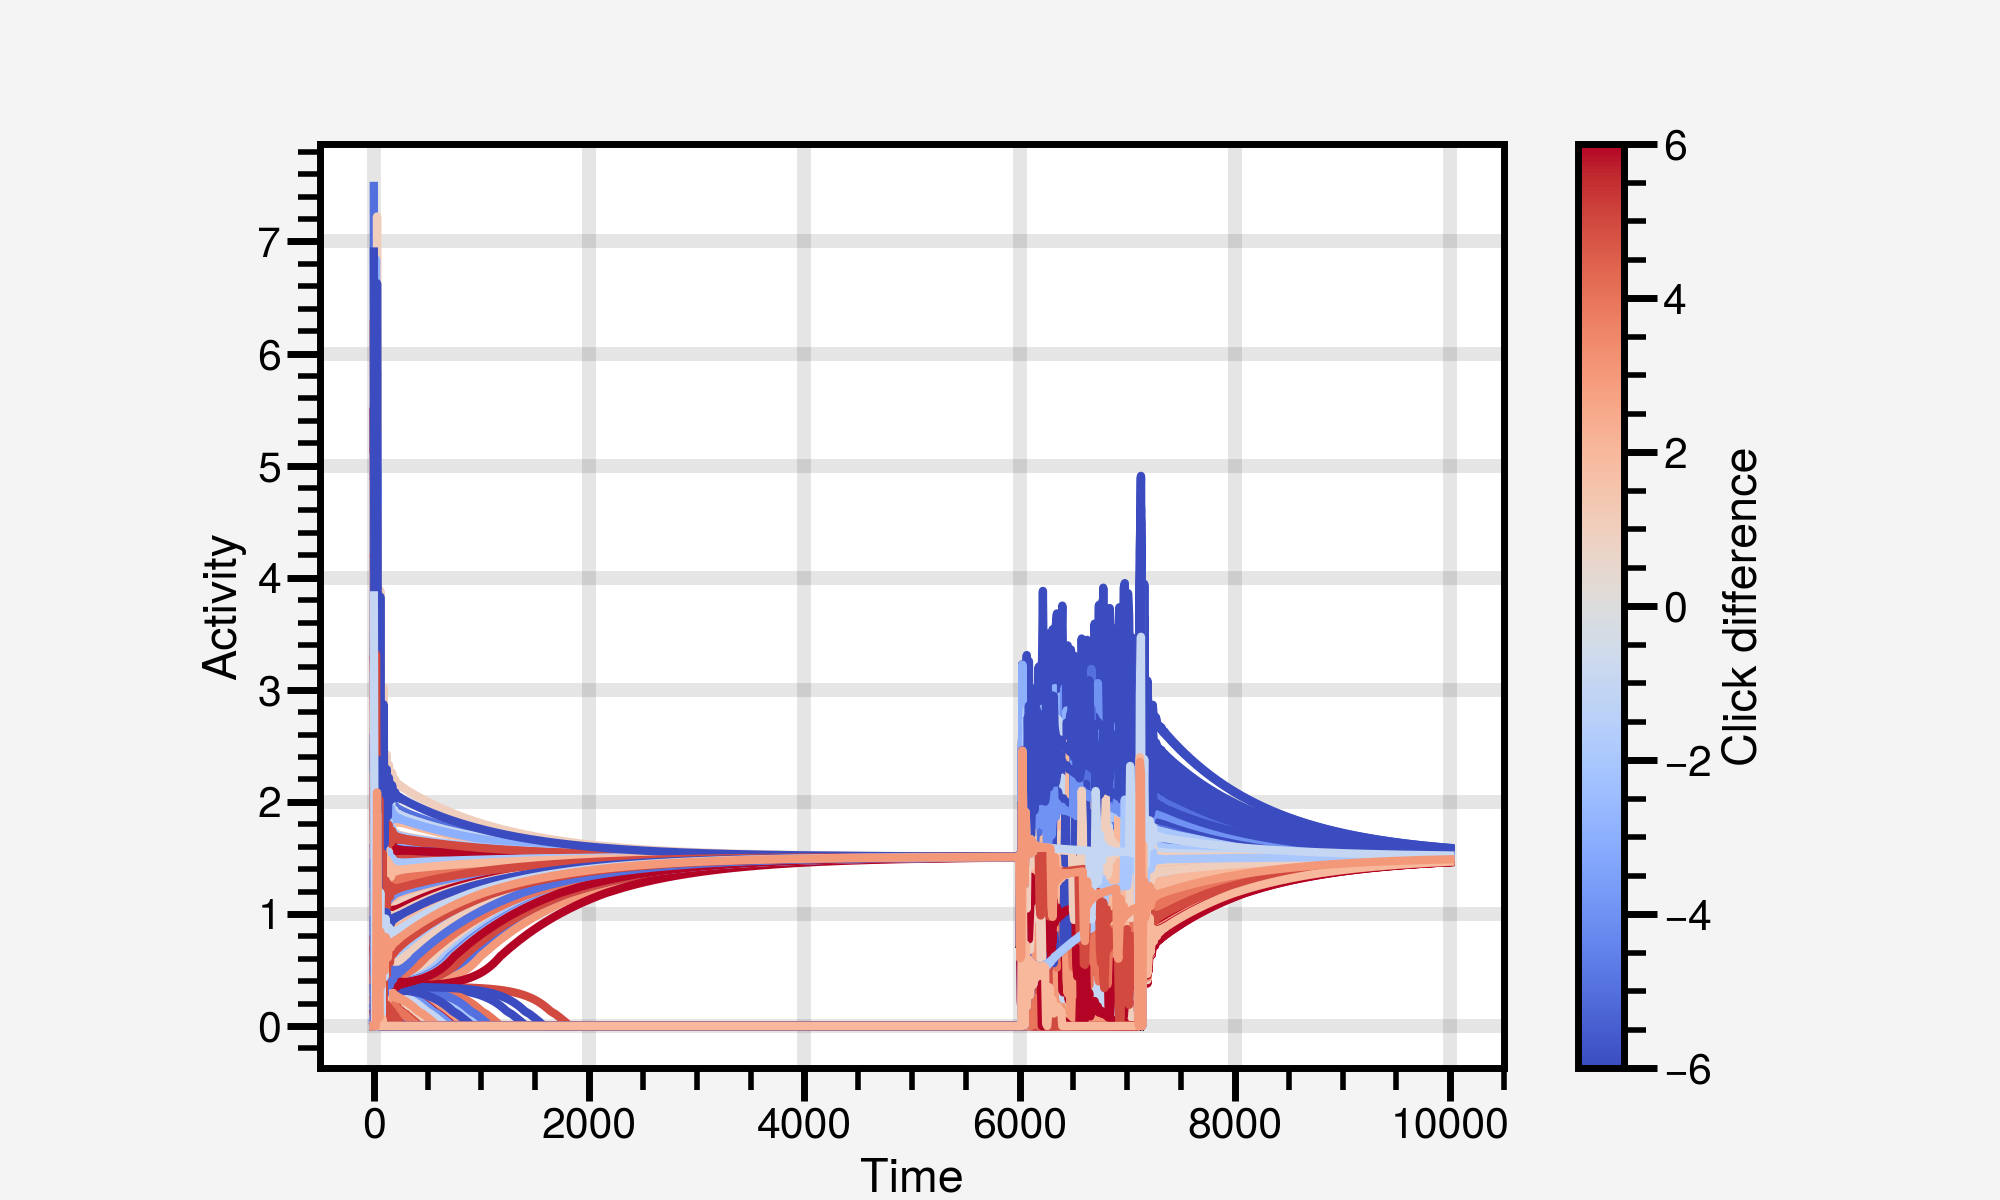

In [384]:
hidden_i = 0
sns.set_context("poster", font_scale = .7, rc={"grid.linewidth": 5})
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

clickdiff = N_clicks[:,0]-N_clicks[:,1]
maxclickdiff=1
cdi = np.where(np.abs(clickdiff)<=maxclickdiff)[0]

# wrong_trials = get_wrong_trials(N_clicks, chosen)
# vextrema = max(clickdiff[wrong_trials])
plot_trajectories_clickdiff(hidden_states[:,...], hidden_i=0, clickdiff=clickdiff[:], vextrema = vextrema, file_name='hidden_activity', path=training_kwargs['figures_path'])

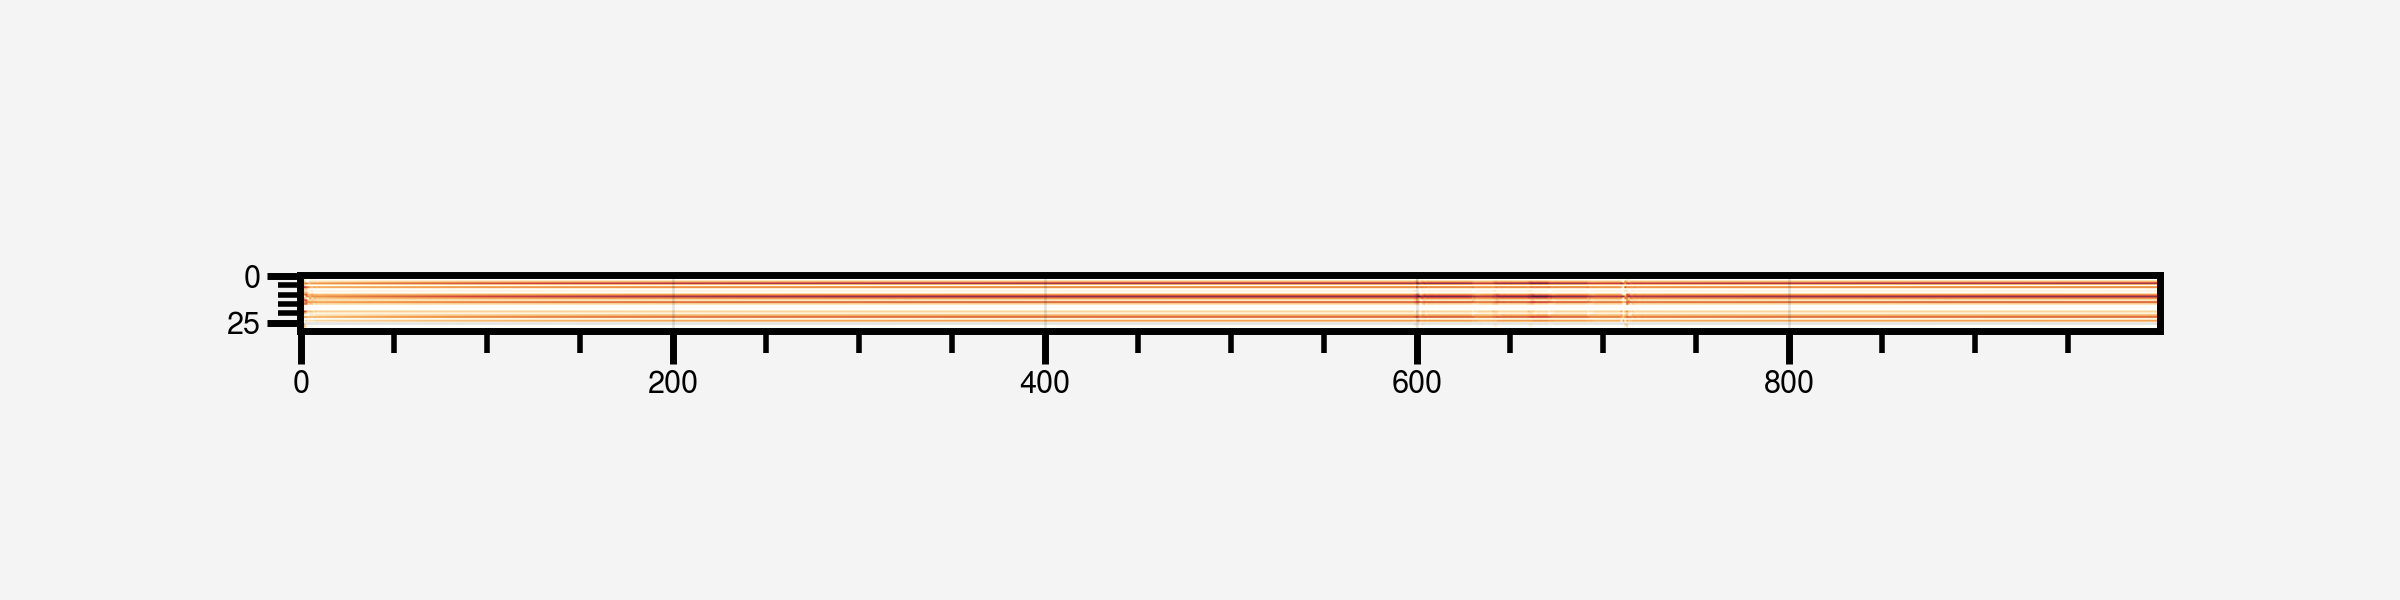

In [438]:
trial_i = 0
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 1})
f = plt.figure(figsize=(12,3))
plt.imshow(hidden_states[trial_i,...].T)

In [445]:
train_x = torch.tensor(x, dtype=torch.float, device=training_kwargs['device'])
hidden = torch.normal(0, training_kwargs['hidden_initial_variance'], (rnn_model.n_layers, train_x.shape[0], rnn_model.hidden_dim)).to(training_kwargs['device']) 

hidden_states, hidden_last = rnn_model.rnn(train_x, hidden)

In [446]:
hidden_last.shape

torch.Size([1, 1000, 30])

(array([37402.,   986.,   688.,   495.,   424.,   325.,   282.,   260.,
          223.,   222.]),
 array([2.9802322e-08, 9.9936558e-05, 1.9984331e-04, 2.9975007e-04,
        3.9965683e-04, 4.9956358e-04, 5.9947034e-04, 6.9937709e-04,
        7.9928385e-04, 8.9919061e-04, 9.9909736e-04], dtype=float32),
 <BarContainer object of 10 artists>)

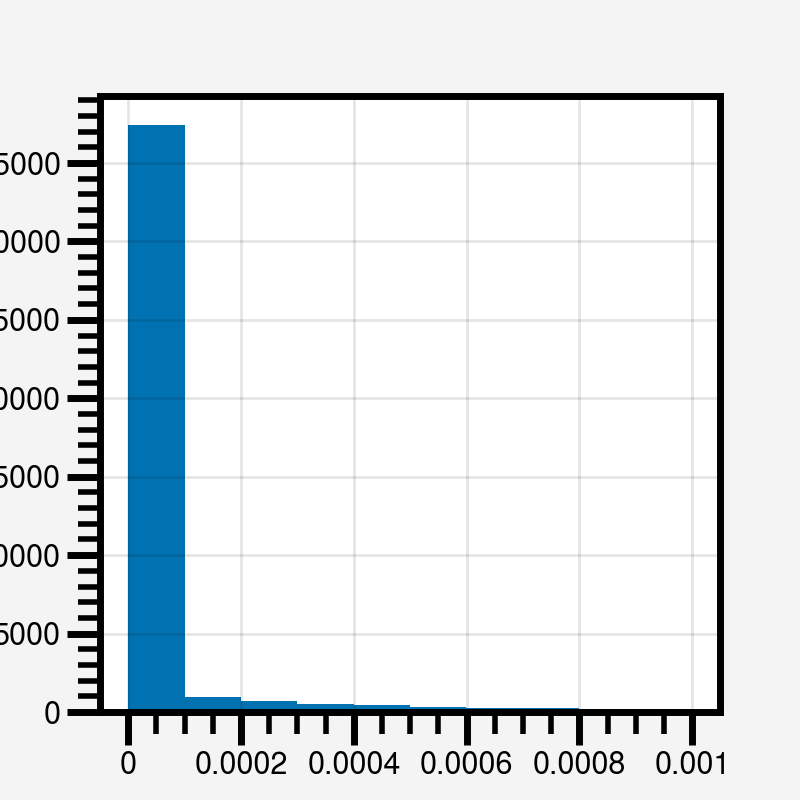

In [441]:
speeds = np.linalg.norm(hidden_states[:,:200-1,:] - hidden_states[:,1:200,:] , axis=-1).flatten()
plt.hist(np.where(speeds<.001, speeds, np.nan))

In [372]:
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

#bin data per click
chosen = np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
chosen_idx = np.where(chosen)[0]

In [373]:
df = pandas.DataFrame.from_records(trial_params)
df = df.round({'ratio': 2})
df['lambdas'] = df['lambdas'].apply(lambda x: np.round(x, 2))

df['hidden'] = hidden_states.tolist()
df['yhat'] =  yhat.tolist()
df['inputs'] =  x.tolist()

In [374]:
clicks_until = np.cumsum(x[:,trial_params[i]['stim_durations_and_pauses'][0]:sum(trial_params[0]['stim_durations_and_pauses']),:2], axis=1)
clickdiff_until = clicks_until[:,:,0] - clicks_until[:,:,1]

first_click_times = (np.sum(clicks_until,axis=-1)!=0).argmax(axis=1)
hidden_states_prestim = [hidden_states[i][10:trial_params[i]['stim_durations_and_pauses'][0],:] for i in range(N_test_batch)]

# hidden_states_input = [hidden_states[i][:trial_params[i]['output_cue'],:] for i in range(N_test_batch)]
hidden_states_input = [hidden_states[i][trial_params[i]['stim_durations_and_pauses'][0]:sum(trial_params[i]['stim_durations_and_pauses']),:] for i in range(N_test_batch)]

hidden_states_output = [hidden_states[i][trial_params[i]['output_cue']:,:] for i in range(N_test_batch)]
df['hidden_states_input'] = hidden_states_input
df['hidden_states_output'] = hidden_states_output

In [375]:
df["Choice"] = chosen
df["Difference"] = N_clicks[:,0]-N_clicks[:,1]
average_perclick = df.groupby("Difference").mean()
neg_click_idx = np.where(df["Difference"]<0.)[0]
pos_click_idx = np.where(df["Difference"]>0.)[0]

### PCA of hidden states before input (pre-stimulus)

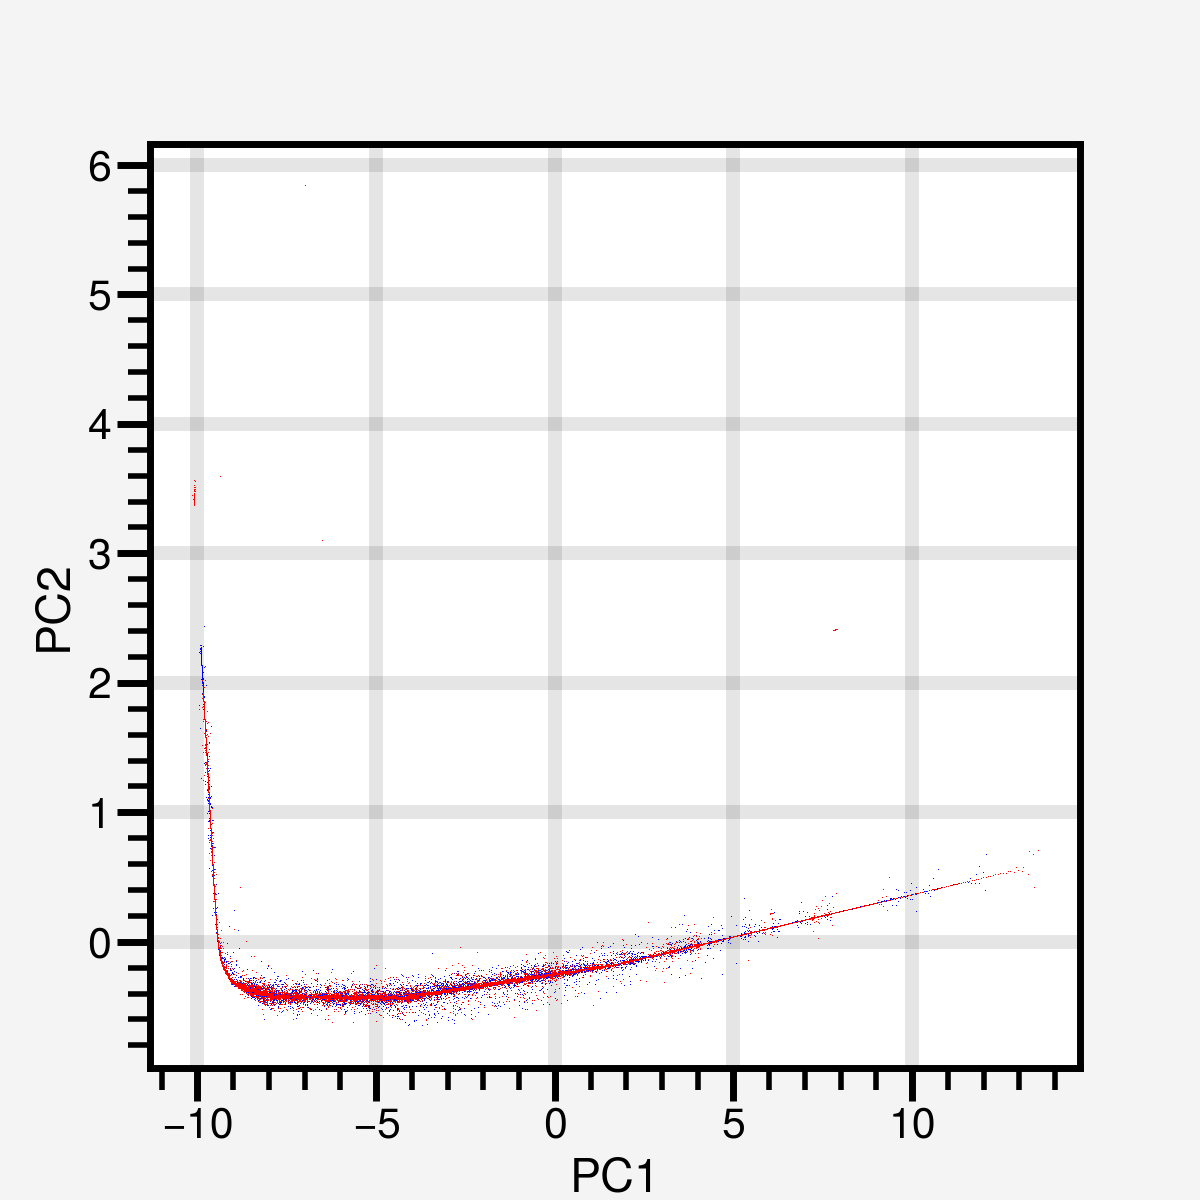

In [376]:
flat_hidden_states_prestim = np.concatenate(hidden_states_prestim)

if training_kwargs['N_rec'] < 11:
    n_components = training_kwargs['N_rec']
else:
    n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(flat_hidden_states_prestim)
trajectories = X_new.reshape((N_test_batch, -1, n_components))

plt.figure(figsize=(6,6))
plt.plot(trajectories[neg_click_idx,:,0], trajectories[neg_click_idx,:,1], 'b,')
plt.plot(trajectories[pos_click_idx,:,0], trajectories[pos_click_idx,:,1], 'r,')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(training_kwargs['figures_path'] + '\\pca_prestim_cohlist_small_ncomp%s.pdf'%(2))
plt.savefig(training_kwargs['figures_path'] + '\\pca_prestim_cohlist_small_ncomp%s.png'%(2))

C:\Users\abel_\AppData\Local\Temp\ipykernel_6104\2754881969.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(hs, ax=ax, label='Click difference')


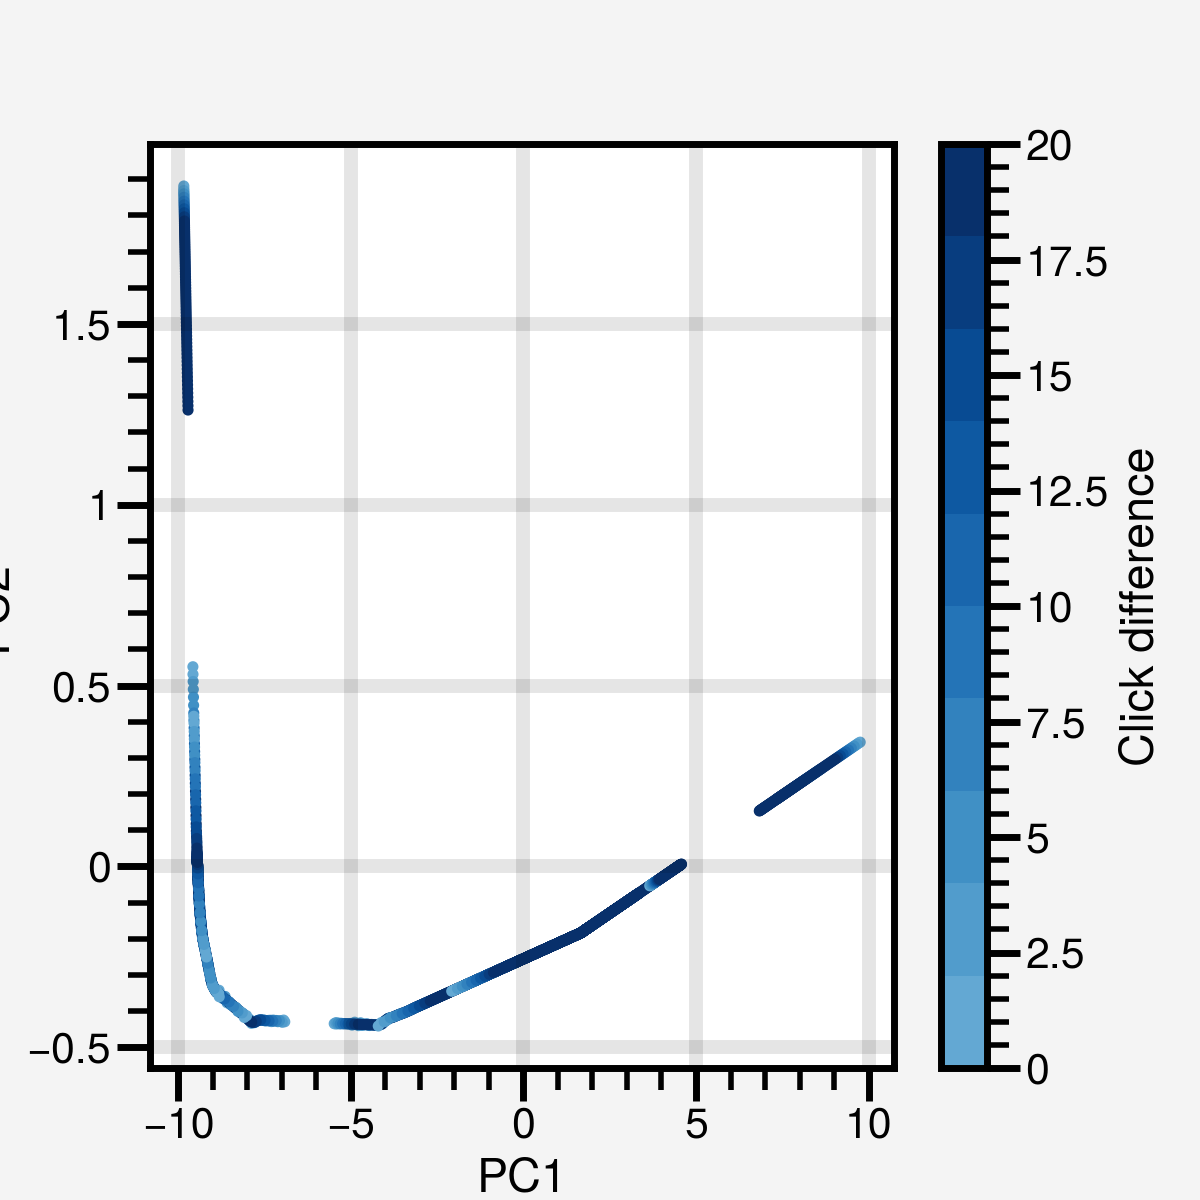

In [377]:
###PCA of hidden states during input: color coded for #clicks until time point
clicks_until = np.cumsum(x, axis=1)

fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
cmap = cm.Blues(np.linspace(0,1,20))
cmap = mplcolors.ListedColormap(cmap[10:,:-1])

N_points = 50
from_t = 20
until_t = 100
for i in range(N_points):
    # hs = ax.scatter(trajectories[i,:,0], trajectories[i,:,1], c=range(trajectories.shape[1]), cmap=cmap, s=4, vmin=0, vmax=601)
    hs = ax.scatter(trajectories[i,from_t:until_t,0], trajectories[i,from_t:until_t,1], c=range(until_t-from_t), cmap=cmap, s=4, vmin=0, vmax=20)
    
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");
fig.colorbar(hs, ax=ax, label='Click difference')

plt.savefig(training_kwargs['figures_path'] + '\\pca_prestimpaths_ncomp%s.pdf'%(2))
plt.savefig(training_kwargs['figures_path'] + '\\pca_prestimpaths_ncomp%s.png'%(2))

### PCA of hidden states during input

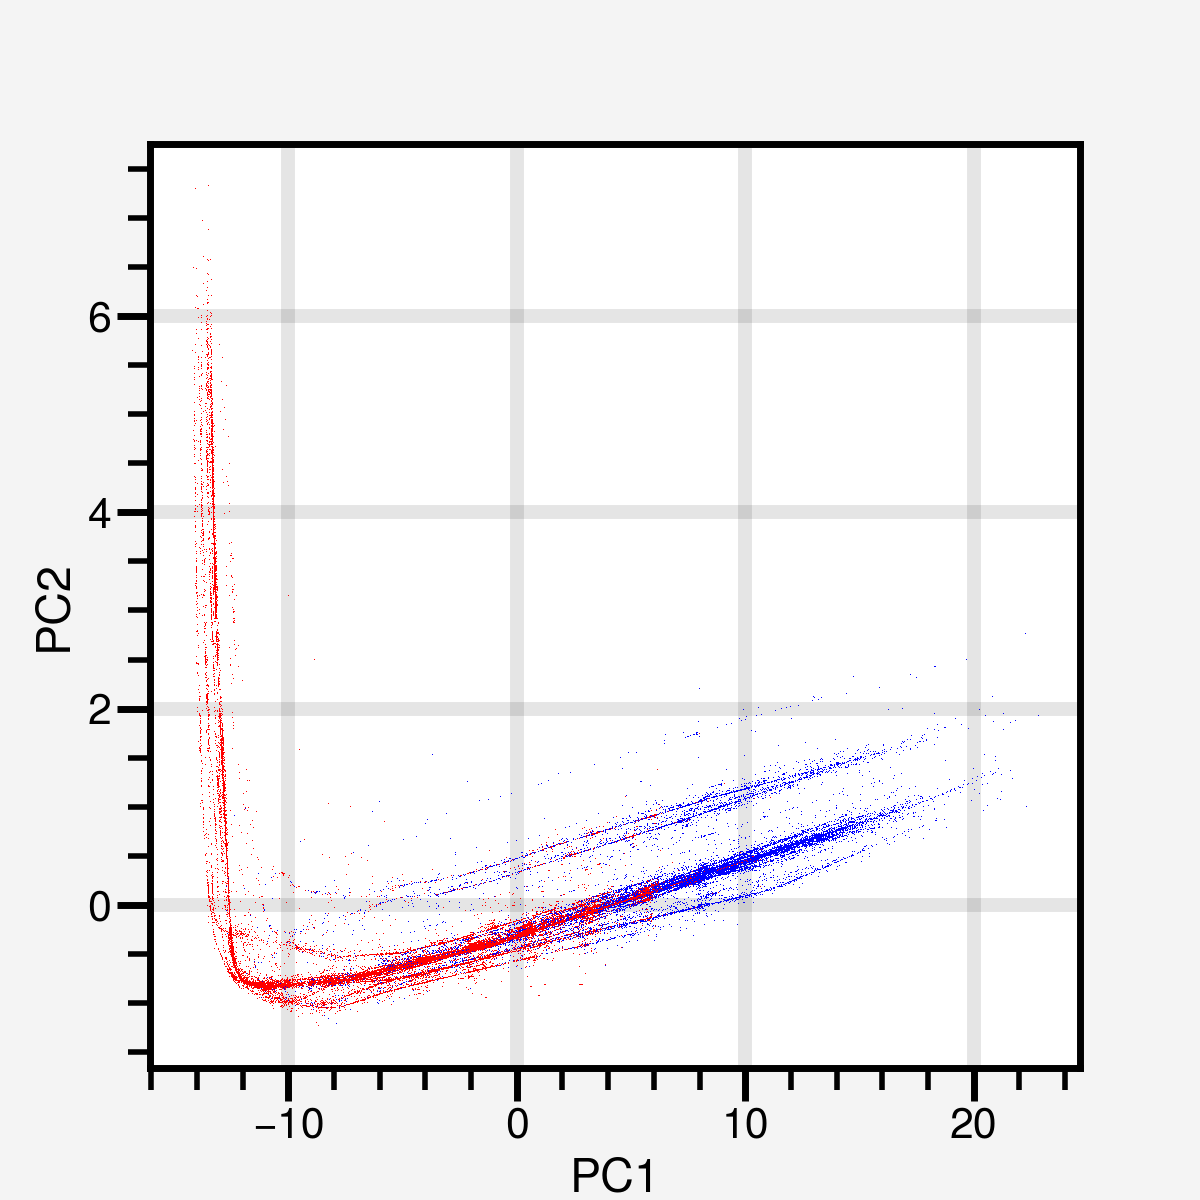

In [378]:
flat_hidden_states_input = np.concatenate(hidden_states_input)

if training_kwargs['N_rec'] < 11:
    n_components = training_kwargs['N_rec']
else:
    n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(flat_hidden_states_input)
trajectories = X_new.reshape((N_test_batch, -1, n_components))

plt.figure(figsize=(6,6))
plt.plot(trajectories[neg_click_idx,:,0], trajectories[neg_click_idx,:,1], 'b,')
plt.plot(trajectories[pos_click_idx,:,0], trajectories[pos_click_idx,:,1], 'r,')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(training_kwargs['figures_path'] + '\\pca_inputs_cohlist_small_ncomp%s.pdf'%(2))
plt.savefig(training_kwargs['figures_path'] + '\\pca_inputs_cohlist_small_ncomp%s.png'%(2))

C:\Users\abel_\AppData\Local\Temp\ipykernel_6104\3029861795.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(hs, ax=ax, label='Click difference')


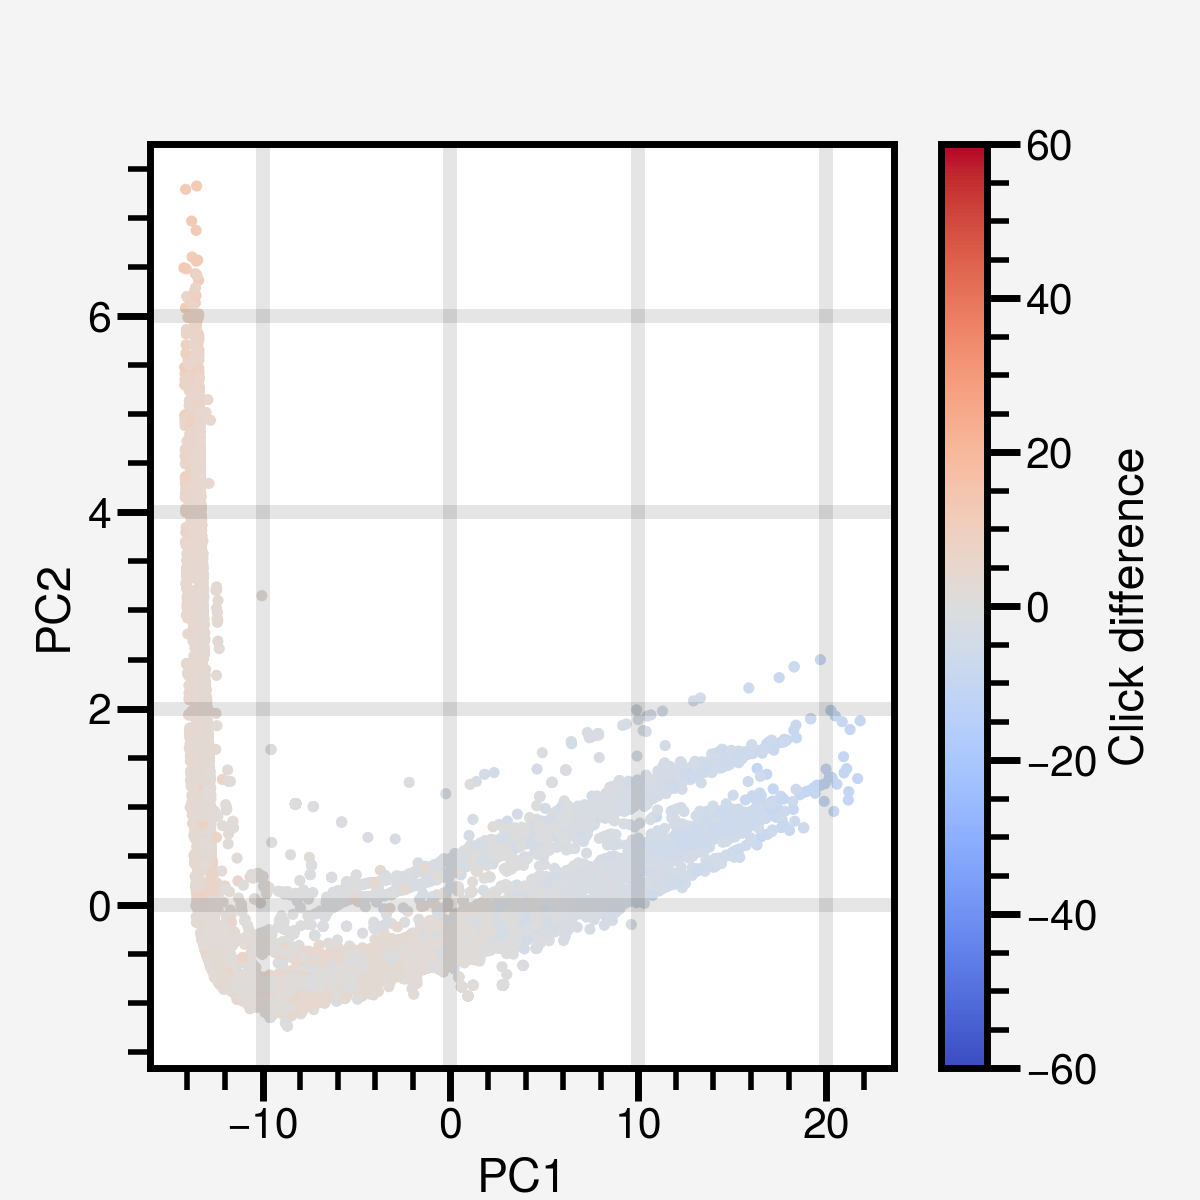

In [379]:
###PCA of hidden states during input: color coded for #clicks until time point
clicks_until = np.cumsum(x, axis=1)

fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
norm = mplcolors.CenteredNorm()
rand_normal_y_norm = norm(clickdiff_until)
cmap = cmx.coolwarm(rand_normal_y_norm)
cmap = cmx.get_cmap("coolwarm")

N_points = 500
direction = np.where(N_clicks[:,0]<N_clicks[:,1],-1,np.where(N_clicks[:,0]>N_clicks[:,1],1,0))

for i in range(N_points):
    # ax.plot(trajectories[i,:,0], trajectories[i,:,1], '-', alpha=0.1, c=colors_list[i-1])
    hs = ax.scatter(trajectories[i,:,0], trajectories[i,:,1], c=clickdiff_until[i,:], s=4, cmap=cmap, vmin=-60, vmax=60)
    
ax.set_xlabel("PC1")
ax.set_ylabel("PC2");
fig.colorbar(hs, ax=ax, label='Click difference')

plt.savefig(training_kwargs['figures_path'] + '\\pca_paths_ncomp%s.pdf'%(2))
plt.savefig(training_kwargs['figures_path'] + '\\pca_paths_ncomp%s.png'%(2))

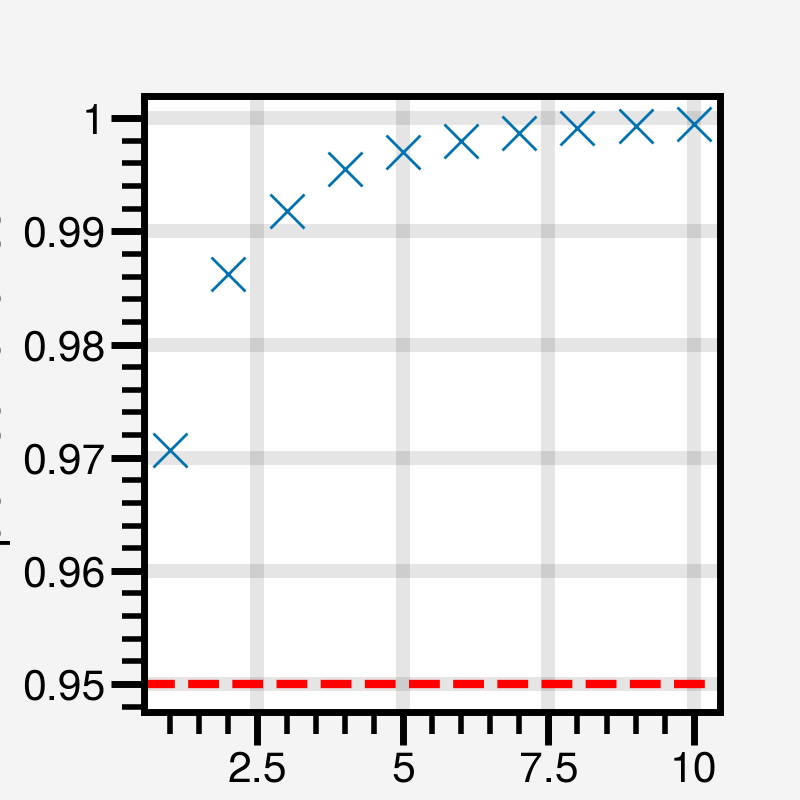

In [380]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.axhline(y=0.95, color = 'r', linestyle = '--')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.gcf().subplots_adjust(left=0.18)

plt.savefig(training_kwargs['figures_path'] + '\\varexpl_input_cohlist.pdf')

C:\Users\abel_\AppData\Local\Temp\ipykernel_6104\520601078.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


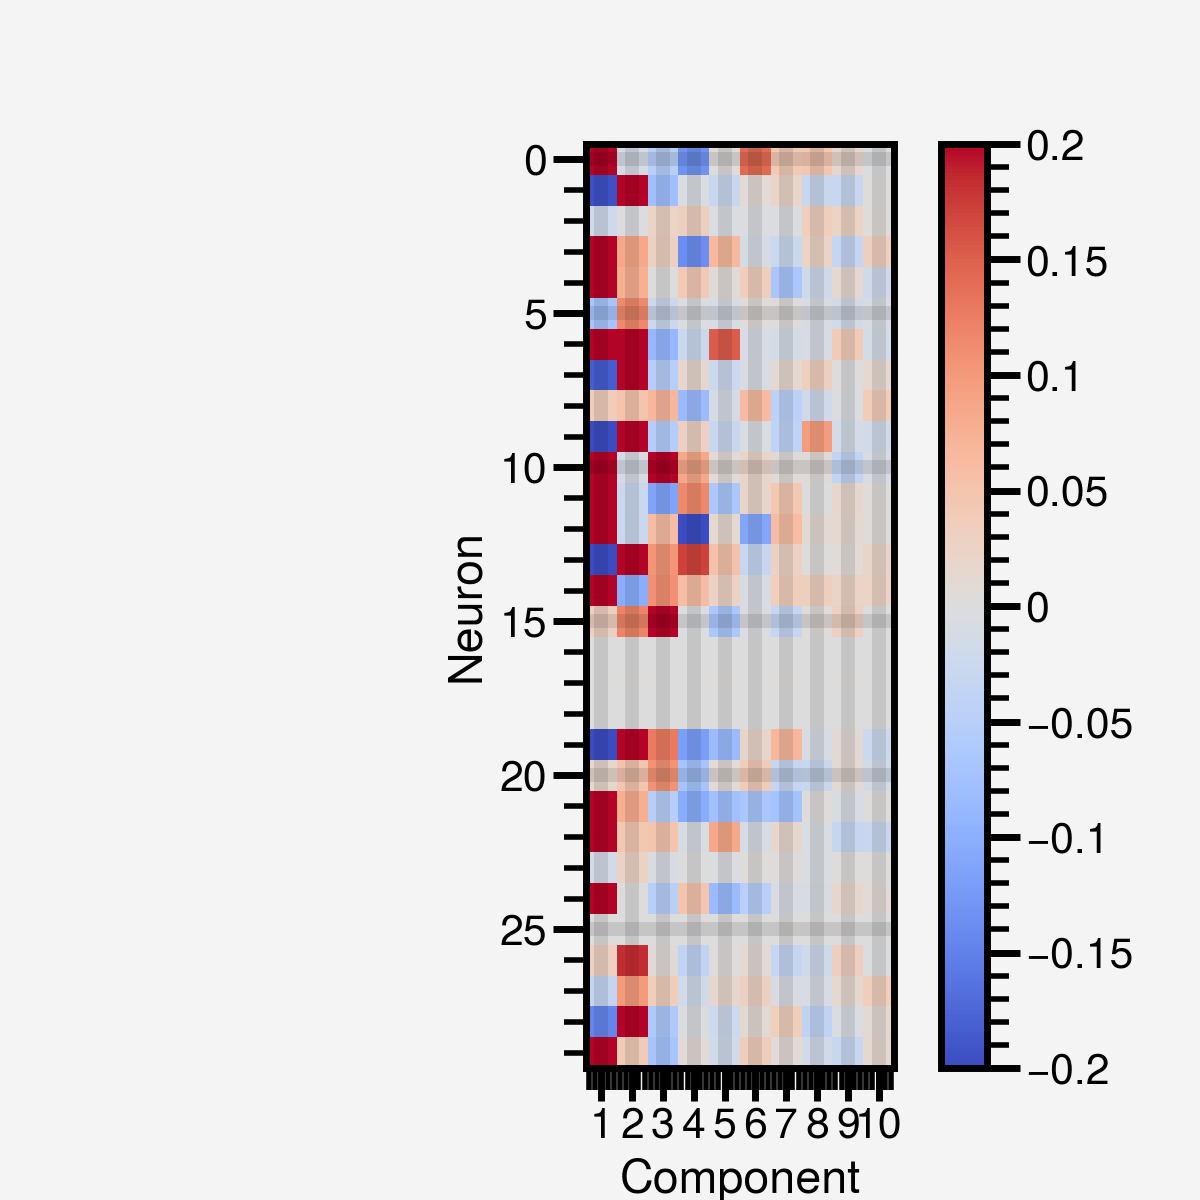

In [381]:
fig=plt.figure(figsize=(6,6))
ax = plt.subplot(111)
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.imshow(loading_matrix, cmap="coolwarm", vmin=-.2, vmax=.2)
plt.xticks(range(0,n_components),range(1,n_components+1))
plt.yticks(range(0,training_kwargs['N_rec'], 5))
plt.xlabel("Component")
plt.ylabel("Neuron")
plt.colorbar()
plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_inputs_cohlist.pdf')
plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_inputs_cohlist.png')

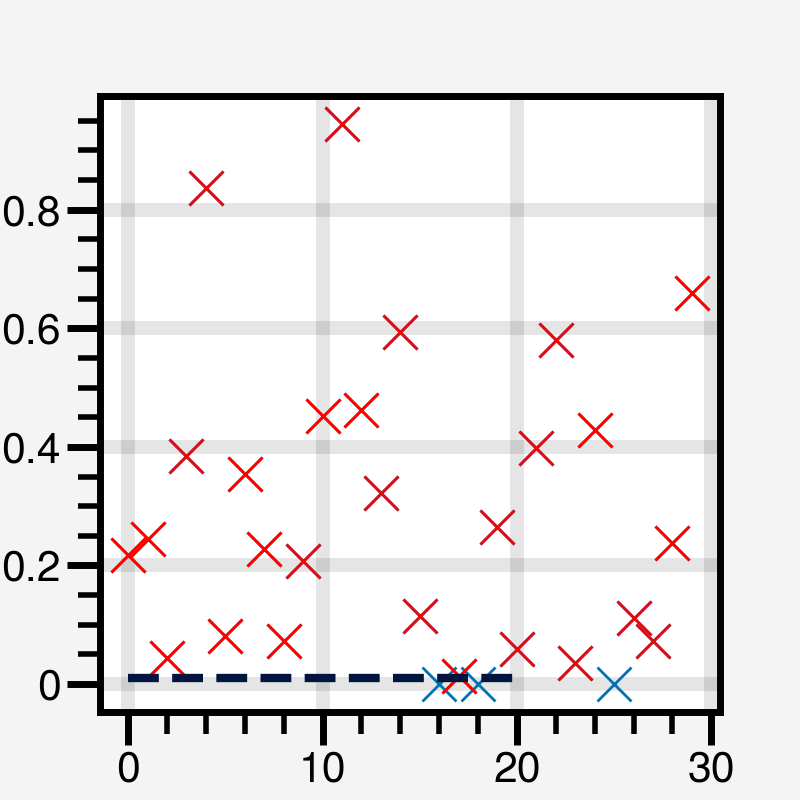

In [78]:
meanabs_lm = np.abs(loading_matrix).mean(axis=1)
plt.plot(meanabs_lm, 'x')
select_idx = np.where(meanabs_lm>0.01)
plt.plot(select_idx[0], meanabs_lm[select_idx], 'rx')
plt.plot([0, 20], [0.01, .01], color="navy", linestyle="--");
plt.xlabel("Neuron");

### Output

In [ ]:
###PCA of hidden states during output

flat_hidden_states_output = np.concatenate(hidden_states_output)

if training_kwargs['N_rec'] < 11:
    n_components = training_kwargs['N_rec']
else:
    n_components = 10
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(flat_hidden_states_output)
trajectories = X_new.reshape((N_test_batch, -1, n_components))

plt.figure(figsize=(6,6))
# plt.plot(X_new[:,0], X_new[:,1], '.')
N_points = 100
# plt.plot(X_new[:N_points,0], X_new[:N_points,1], '.')
plt.plot(trajectories[neg_click_idx,:,0], trajectories[neg_click_idx,:,1], 'b.')
plt.plot(trajectories[pos_click_idx,:,0], trajectories[pos_click_idx,:,1], 'r.')
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.savefig(training_kwargs['figures_path'] + '\\pca_outputs_cohlist_small_ncomp%s.pdf'%(2))
plt.savefig(training_kwargs['figures_path'] + '\\pca_outputs_cohlist_small_ncomp%s.png'%(2))

In [ ]:
loading_matrix = pca.components_.T * np.sqrt(pca.explained_variance_)
plt.imshow(loading_matrix)
plt.xticks(range(0,n_components),range(1,n_components+1))
plt.yticks(range(0,training_kwargs['N_rec'], 5))
plt.xlabel("Component")
plt.ylabel("Neuron")
plt.colorbar()
plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_outputs_cohlist.pdf')
plt.savefig(training_kwargs['figures_path'] + '\\loadingmat_outputs_cohlist.png')

In [ ]:
# pca.get_covariance()
plt.plot(range(1, n_components+1), pca.explained_variance_ratio_.cumsum(), 'x')
plt.axhline(y=0.95, color = 'r', linestyle = '--')
plt.xlabel("Dimension")
plt.ylabel("Explained variance");
plt.gcf().subplots_adjust(left=0.18)

plt.savefig(training_kwargs['figures_path'] + '\\varexpl_output_cohlist.pdf')

In [ ]:
trajectories = hidden_states_input
# trajectories = hidden_states_output

In [ ]:
pca = sklearn.decomposition.PCA(n_components=n_components)
X_new = pca.fit_transform(flat_hidden_states_input)

# pca = sklearn.decomposition.PCA(n_components=n_components)
# X_new = pca.fit_transform(flat_hidden_states_output)

trajectories = X_new.reshape((N_test_batch, -1, n_components))

In [ ]:
nbins = 5
neg_bins = np.flip(np.linspace(-60, -1, nbins, dtype=int))
neg_diff_bins = np.digitize(df["Difference"], neg_bins)

pos_bins = np.linspace(1, 60+1, nbins, dtype=int)
pos_diff_bins = np.digitize(df["Difference"], pos_bins)

np_diff_bins = [neg_diff_bins, pos_diff_bins]

# bin_means = [[trajectories[(diff_bins==i) & (chosen==j),...].sum(axis=0) for i in range(1, len(bins))] for j in [0,1]]
bin_means = [[trajectories[np_diff_bins[j]==i,...].sum(axis=0) for i in range(1, nbins)] for j in [0,1]]

In [ ]:
fig=pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
bin_i = 0
time_steps=bin_means[0][0].shape[0]
times = np.linspace(0, time_steps*10,  time_steps)

colors = ['r', 'b']
markers = ['+', '_', 'x', '*', '.']
cmaps=[plt.get_cmap('blues') , plt.get_cmap('reds')]
hss = [0,1]
for bin_j in range(len(bin_means)):
    choice_bins = bin_means[bin_j]
    for bin_i in range(len(choice_bins)):

        hs = ax.scatter(choice_bins[bin_i][:,0], choice_bins[bin_i][:,1], 
                   marker=markers[bin_i], color=colors[bin_j])


f = lambda m,c: ax.plot([],[], marker=m, color=c, ls="none")[0]


handles = [f("s", colors[i]) for i in range(2)]
handles += [f(markers[i], "k") for i in range(nbins)]

labels = [] 
labels.extend(["Positive", "Negative"])
for n in range(pos_bins.size-1):
    labels.append(r"[" + str(pos_bins[n]) + r"," + str(pos_bins[n+1]-1) + "]")
# labels.extend(["+", "-"])

ax.legend(handles[:2], labels[:2], 
           title="Click difference", framealpha=1,
           loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=2)

ax.legend(handles[2:], labels[2:], 
           title="Click difference", framealpha=1,
           loc='r',          ncol=1)

fig.format(abc=True, xlabel='PC1', ylabel='PC2')

In [ ]:
fig=pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
bin_i = 0
time_steps=bin_means[0][0].shape[0]
times = np.linspace(0, time_steps*10,  time_steps)

colors = ['r', 'b']
markers = ['+', '_', 'x', '*', '.']
cmaps=[plt.get_cmap('blues') , plt.get_cmap('reds')]
hss = [0,1]
for bin_j in range(len(bin_means)):
    choice_bins = bin_means[bin_j]
    for bin_i in range(len(choice_bins)):

        # hs = ax.scatter(choice_bins[bin_i][:,0], choice_bins[bin_i][:,1], 
        #            marker=markers[bin_i], color=colors[bin_j])
        hss[bin_j] = ax.scatter(choice_bins[bin_i][:,0], choice_bins[bin_i][:,1], 
                    marker=markers[bin_i], #color=colors[bin_j],
                    vmin=-time_steps*3, vmax=time_steps*10, cmap=cmaps[bin_j],
                    c=times, zorder=3)

f = lambda m,c: ax.plot([],[], marker=m, color=c, ls="none")[0]


handles = [f("s", colors[i]) for i in range(2)]
handles += [f(markers[i], "k") for i in range(nbins)]

labels = [] 
labels.extend(["Positive", "Negative"])
for n in range(pos_bins.size-1):
    labels.append(r"[" + str(pos_bins[n]) + r"," + str(pos_bins[n+1]-1) + "]")
# labels.extend(["+", "-"])

# ax.legend(handles[:2], labels[:2], 
#            title="Click difference", framealpha=1,
#            loc='upper center', bbox_to_anchor=(0.5, -0.18),
#           fancybox=True, shadow=True, ncol=2)

ax.legend(handles[2:], labels[2:], 
           title="Click difference", framealpha=1,
           loc='b', ncol=4)
# fig.colorbar(hs, cax=cb_ax, fraction=0.5, pad=0.04).set_ticks([])
# fig.colorbar(hs, cax=cb_ax2, fraction=0.5, pad=0.04).set_label('Time (ms)',rotation=90)
ax.colorbar(hss[0], loc='r',length=.6, ticks=[])
ax.colorbar(hss[1], loc='r',length=.6, label='Time (ms)')

fig.format(abc=True, xlabel='PC1', ylabel='PC2')

# 

In [ ]:
# def plot_clickdiff_trajectories(trajectories, trial_params, 
#                                training_kwargs,
#                                 unstable_fixedpoint=None, N_trial_plot=0, point_size = 2, label_text="Neuron",
#                                cmaps=[plt.get_cmap('blues') , plt.get_cmap('reds')],
#                             coherence_labels=['26:14', '31:9', '37:3', '39:1'],
#                                save_name='trajectories_fixedduronset_cohdir_condmean'):